[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/p-lod/p-lod-coookbook/blob/main/local-rdf.ipynb)

In [32]:
import sys

try:
    import rdflib
except ImportError:
    !{sys.executable} -m pip install -q rdflib requests
    import rdflib

import gzip
import matplotlib
import pandas as pd
import requests

from string import Template

In [5]:
# URL of the pickled rdf graph object
url = "https://github.com/p-lod/downloads/releases/download/latest/p-lod-rdf-graph.nt.gz"


In [6]:
# This usually cell takes between 25 and 90 seconds to run. Seems to all depend on external factors
# such as any at-the-moment caching by the Github CDN and overall connection speed. Various setups were tested. 
# Streamed loading of a gzip-compressed .nt file seemed fastest. GitHub releases wasn't the absolute 
# fastest CDN but is straightforward and not much slower than Cloudflare R2.

with requests.get(url, stream=True, allow_redirects=True) as r:
    r.raise_for_status()
    with gzip.GzipFile(fileobj=r.raw) as f:
        g = rdflib.Graph().parse(f, format='nt')

print(f"Graph loaded from URL contains {len(g)} triples.")

Graph loaded from URL contains 2821116 triples.


In [17]:
# add urn:p-lod:id: as the default prefix in g
g.bind("", "urn:p-lod:id:")

In [36]:
# should run pretty quickly. under a second.

identifier = "olympian_deity"

q = Template("""
SELECT ?depicted (COUNT(?depicted) as ?count) WHERE {
    ?component :depicts ?depicted .
    ?depicted :broader+ :$identifier .
} GROUP BY ?depicted
""").substitute(identifier = identifier)


results = g.query(q)

df = pd.DataFrame(results, columns=[str(v) for v in results.vars])
df['count'] = pd.to_numeric(df['count'])

df.head()


,depicted,count
0,urn:p-lod:id:apollo,64
1,urn:p-lod:id:ares,7
2,urn:p-lod:id:poseidon,10
3,urn:p-lod:id:hera,11
4,urn:p-lod:id:dionysus,88


<Axes: xlabel='depicted'>

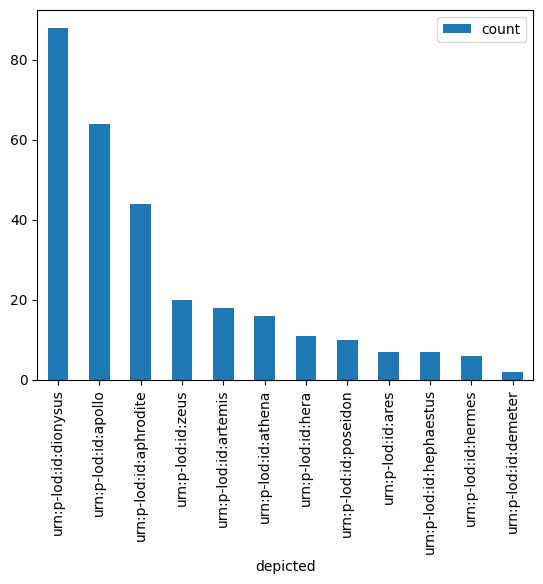

In [40]:
df.sort_values(by="count", ascending = False).plot.bar(x='depicted')

In [20]:
# This is a more complex query that assocaites space characterizations - basically room function -
# with depicted concepts - basically motifs such "garland" or "ariadne".
# Usually runs in under 5 seconds on an M4 MacBook with 16 gig of RAM.

results = g.query("""SELECT DISTINCT ?space ?characterization ?feature ?concept WHERE {
  ?component :depicts ?concept .
  ?concept a :concept .

  ?component :is-part-of+/:created-on-surface-of ?feature .
  ?feature :spatially-within ?space .
  OPTIONAL { ?space :has-space-characterization ?characterization}

} ORDER BY ?space ?feature ?concept """)

sfc_df = pd.DataFrame(results, columns=[str(v) for v in results.vars])


display(sfc_df)

,space,characterization,feature,concept
0,urn:p-lod:id:r1-i1-p1-space-via-stabiana,NaN,urn:p-lod:id:ARC_025510,urn:p-lod:id:dipinto
1,urn:p-lod:id:r1-i10-p1-space-1,urn:p-lod:id:hall,urn:p-lod:id:ARC_021435,urn:p-lod:id:garland
2,urn:p-lod:id:r1-i10-p1-space-1,urn:p-lod:id:hall,urn:p-lod:id:ARC_021435,urn:p-lod:id:lare
3,urn:p-lod:id:r1-i10-p1-space-1,urn:p-lod:id:hall,urn:p-lod:id:ARC_021438,urn:p-lod:id:cross
4,urn:p-lod:id:r1-i10-p1-space-1,urn:p-lod:id:hall,urn:p-lod:id:ARC_021438,urn:p-lod:id:fruit
...,...,...,...,...
37715,urn:p-lod:id:r9-i9-pg-space-f,urn:p-lod:id:room,urn:p-lod:id:ARC_016436,urn:p-lod:id:frieze
37716,urn:p-lod:id:r9-i9-pg-space-f,urn:p-lod:id:room,urn:p-lod:id:ARC_016437,urn:p-lod:id:circle
37717,urn:p-lod:id:r9-i9-pg-space-f,urn:p-lod:id:room,urn:p-lod:id:ARC_016437,urn:p-lod:id:fruit
37718,urn:p-lod:id:r9-i9-pg-space-f,urn:p-lod:id:room,urn:p-lod:id:ARC_016437,urn:p-lod:id:graffito


In [ ]:
# utility cell to save as nt.gz. only one half of process. ignore for now. honestly, it doesnt
# really belong here. ignore.

with gzip.open('p-lod-rdf-graph.nt.gz', 'wb') as f:
    g.serialize(destination=f, format='nt')
print("RDF graph saved as 'p-lod-rdf-graph.nt.gz'")